# New methos for mobius optimization

In [1]:
# Import basic libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import time
from sklearn.preprocessing import LabelEncoder
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # for 3D projection
import os
import time
import tracemalloc
import psutil
plt.style.use('_mpl-gallery')
os.chdir("/Users/hoangthuyduongvu/Desktop/FuzzSIM")


In [2]:
# Import personalized libraries
from fuzz.src.capacity import *
from fuzz.choquet.choquet import *
from fuzz.src.norm import *
from fuzz.src.knn import KNNFuzz
from fuzz.src.sim import S1, S2, S3
from fuzz.optim import *
from fuzz.utils import *
from fuzz.eval import leave_one_out
from fuzz.dataloader import *
from fuzz.choquet.d_choquet import *

In [3]:
# Use timestamps for saving results
timestamp = time.strftime("%Y%m%d-%H%M%S")

# Create a directory for results if it doesn't exist
results_dir = "results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

if not os.path.exists(os.path.join(results_dir, timestamp)):
    os.makedirs(os.path.join(results_dir, timestamp))

In [4]:
# Load data 
iris_data = load_iris()
iris = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris['target'] = iris_data.target
data, labels = iris.iloc[:, :-1].values, iris.iloc[:, -1].values
data = batch_norm(np.array(data, dtype=np.float32))
data[:5]

array([[1.        , 0.67346936, 0.24489795, 0.        ],
       [1.        , 0.59574461, 0.25531912, 0.        ],
       [1.        , 0.66666669, 0.24444443, 0.        ],
       [1.        , 0.65909088, 0.29545453, 0.        ],
       [1.        , 0.70833325, 0.24999997, 0.        ]])

In [5]:
# Generate all possible mobius for training
features = list(range(len(data[0])))    # encode features as integers

nb_total = 5

# Input Mobius (10 mobius currently)
lst_mobius = []
for i in range(nb_total):
    mobius = generate_mobius(features, 2)
    mobius.pop(0)
    lst_mobius.append(mobius)

# Mutate all mobius
mutated = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    mutated_mobius = mutate(mobius, mutation_rate=0.8)
    mutated.append(mutated_mobius)

# Add mutated mobius to the list
lst_mobius.extend(mutated)

# Cross over all mobius
crossed_over = []
for i in range(len(lst_mobius)):
    for j in range(i + 1, len(lst_mobius) // 2):
        crossed = crossover(lst_mobius[np.random.randint(len(lst_mobius))], lst_mobius[np.random.randint(len(lst_mobius))])
        crossed_over.append(crossed)

# Add crossed over mobius to the list
lst_mobius.extend(crossed_over)
print(f"Total number of Möbius measures: {len(lst_mobius)}")

# Convert all Möbius measures to capacities
capacities_list = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    capacity = mobius_to_capacity(mobius, features)
    capacities_list.append(capacity)    
print('Test Möbius measures completed!')
print(f"Total number of capacities: {len(capacities_list)}")

Total number of Möbius measures: 20
Test Möbius measures completed!
Total number of capacities: 20


In [6]:
# Define memory tracker
tracemalloc.start()
get_memory_usage_mb()

186.515625

In [ ]:
import numpy as np
import time
import copy

# Hill Climbing parameters
max_iterations = 100
step_size = 0.1
tolerance = 1e-6
num_restarts = 1  # Multiple random starts

# Fixed hyperparameters (you can adjust these)
p_val = .25
q_val = 1.
sim = S2  # your similarity measure
choquet_version = 'd_choquet'  # using d_choquet as specified
verbose = True
eval_type = 'loo'  # using LOO as specified
sim_agent = 'capacity'

print("Starting Hill Climbing optimization for single Möbius measure...")
start_time = time.time()

# Store best results across all restarts
global_best_mobius = None
global_best_accuracy = -float('inf')
global_best_history = []


for restart in range(num_restarts):
    print(f"\n--- Restart {restart + 1}/{num_restarts} ---")

    # Initialize random starting point
    if len(lst_mobius) > 0:
        # Start from a random Möbius measure in your list
        current_mobius = generate_capacity(enumerate_permute_unit(data[0]))
    else:
        print("Warning: lst_mobius is empty, you need to initialize Möbius measures")
        continue

    # Evaluate initial Möbius measure
    current_fitness = FuzzLOO(
        DS=(data, labels),
        mu=current_mobius,
        sim=sim,
        choquet_version=choquet_version,
        p=p_val,
        q=q_val,
    )
    
    current_accuracy = current_fitness  # Convert back to accuracy
    
    print(f"Initial accuracy: {current_accuracy:.4f}")
    
    # Hill climbing iterations
    iteration_history = [current_accuracy]
    
    for iteration in range(max_iterations):
        improved = False
        best_neighbor = None
        best_neighbor_accuracy = current_accuracy
        
        # Generate neighbors by perturbing the Möbius measure
        neighbors = []
        
        # Create neighbors by adding/subtracting step_size to each Capacity element
        for i in range(len(current_mobius)):
            # For each Capacity element in the Möbius measure
            for direction in [-1, 1]:
                neighbor_mobius = copy.deepcopy(current_mobius)
                
                if len(neighbor_mobius[i].X) not in [0, len(data[0])]:
                    # Perturb the mu value (which is a single float in Capacity class)
                    perturbation = direction * step_size * np.random.uniform(0.5, 1.5)
                    neighbor_mobius[i].mu = neighbor_mobius[i].mu + perturbation
                    
                    # Ensure mu values stay within valid bounds [0, 1]
                    neighbor_mobius[i].mu = np.clip(neighbor_mobius[i].mu, 0, 1)
                elif len(neighbor_mobius[i].X) == 0:
                    neighbor_mobius[i].mu = 0.0  # If empty, set mu to 0
                elif len(neighbor_mobius[i].X) == len(data[0]):
                    neighbor_mobius[i].mu = 1.0

                if is_monotonic(neighbor_mobius):
                    neighbors.append(neighbor_mobius)

        # Also try perturbing all elements simultaneously (global perturbation)
        for direction in [-1, 1]:
            neighbor_mobius = copy.deepcopy(current_mobius)
            for i in range(len(neighbor_mobius)):
                perturbation = direction * step_size * np.random.uniform(0.1, 0.3)
                neighbor_mobius[i].mu = neighbor_mobius[i].mu + perturbation
                neighbor_mobius[i].mu = np.clip(neighbor_mobius[i].mu, 0, 1)
            neighbors.append(neighbor_mobius)
        
        # Evaluate all neighbors
        if neighbors:
            # Evaluate each neighbor individually
            neighbor_accuracies = []
            for neighbor in neighbors:
                try:
                    neighbor_fitness = FuzzLOO(
                        DS=(data, labels),
                        mu=neighbor,
                        sim=sim,
                        choquet_version=choquet_version,
                        p=p_val,
                        q=q_val,
                    )
                    neighbor_accuracies.append(neighbor_fitness)  # Convert to accuracy
                except:
                    neighbor_accuracies.append(float('inf'))  # Penalize invalid neighbors
            
            # Find best neighbor
            best_neighbor_idx = np.argmax(neighbor_accuracies)
            best_neighbor_accuracy = neighbor_accuracies[best_neighbor_idx]
            
            # Check if we found an improvement
            if best_neighbor_accuracy > current_accuracy + tolerance:
                current_mobius = neighbors[best_neighbor_idx]
                current_accuracy = best_neighbor_accuracy
                improved = True
                
                if verbose and iteration % 5 == 0:
                    print(f"Iteration {iteration}: Accuracy improved to {current_accuracy:.4f}")
        
        iteration_history.append(current_accuracy)
        
        # Stop if no improvement
        if not improved:
            print(f"Converged at iteration {iteration}")
            break
        
        # Adaptive step size (optional)
        if iteration > 10 and len(iteration_history) > 5:
            recent_improvement = iteration_history[-1] - iteration_history[-6]
            if recent_improvement < tolerance:
                step_size *= 0.9  # Reduce step size if improvement is slow
                if verbose:
                    print(f"Reduced step size to {step_size:.4f}")
    
    print(f"Final accuracy for restart {restart + 1}: {current_accuracy:.4f}")
    
    # Update global best
    if current_accuracy > global_best_accuracy:
        global_best_accuracy = current_accuracy
        global_best_mobius = copy.deepcopy(current_mobius)
        global_best_history = iteration_history.copy()

end_time = time.time()
print(f"\n=== Hill Climbing Results ===")
print(f"Best accuracy found: {global_best_accuracy:.4f}")
print(f"Total time: {end_time - start_time:.2f} seconds")


# Store results
hill_climbing_best_mobius = global_best_mobius
hill_climbing_best_accuracy = global_best_accuracy

print(f"\nOptimized Möbius measure stored in: hill_climbing_best_mobius")
print(f"Best LOO accuracy stored in: hill_climbing_best_accuracy")

# # Compare with your grid search results if available
# if len(best_accuracies) > 0:
#     grid_search_best = max(best_accuracies)
#     print(f"\nComparison:")
#     print(f"Grid Search best LOO accuracy: {grid_search_best:.4f}")
#     print(f"Hill Climbing best LOO accuracy: {hill_climbing_best_accuracy:.4f}")
#     print(f"Improvement: {hill_climbing_best_accuracy - grid_search_best:.4f}")

# Test the optimized Möbius measure
print(f"\n=== Testing Optimized Möbius ===")
bst_acc = mobius_to_capacity(hill_climbing_best_mobius, features)
final_acc = FuzzLOO(
    DS=(data, labels),
    mu=bst_acc,
    sim=S2,
    choquet_version='d_choquet',
    p=p_val,
    q=q_val,
)

final_test_accuracy = final_acc
print(f"Final verification - LOO accuracy: {final_test_accuracy:.4f}")
print(f"Best LOO accuracy from hill climbing: {hill_climbing_best_accuracy:.4f}")

Starting Hill Climbing optimization for single Möbius measure...

--- Restart 1/1 ---
Initial accuracy: 0.3333
Iteration 0: Accuracy improved to 0.3800


In [ ]:
# Define memory tracking end time
current, peak = tracemalloc.get_traced_memory()
print(f"Current memory: {current / 1024**2:.2f} MB; Peak: {peak / 1024**2:.2f} MB")
tracemalloc.stop()
get_memory_usage_mb()

Current memory: 1.99 MB; Peak: 2.21 MB


50.6875

In [ ]:
results = []
res_mobius = []  # Use the best mobius measure
res_capacity = []  # Use the best capacity

for i in range(len(data)):
    choquet_mobius = Choquet(X=data[i], mu=hill_climbing_best_mobius, version='linear', p=p_val, q=q_val)
    choquet_capa = Choquet(X=data[i], mu=bst_acc, version='d_choquet', p=p_val, q=q_val)

    results.append({
        'index': i,
        'mobius_value': choquet_mobius.choquet,
        'capacity_value': choquet_capa.choquet,
        'label': labels[i]
    })
    res_mobius.append(choquet_mobius.choquet)
    res_capacity.append(choquet_capa.choquet)

# Save results to a txt file
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(results_dir, timestamp, 'choquet_mobius_results_iris.txt'), index=False)

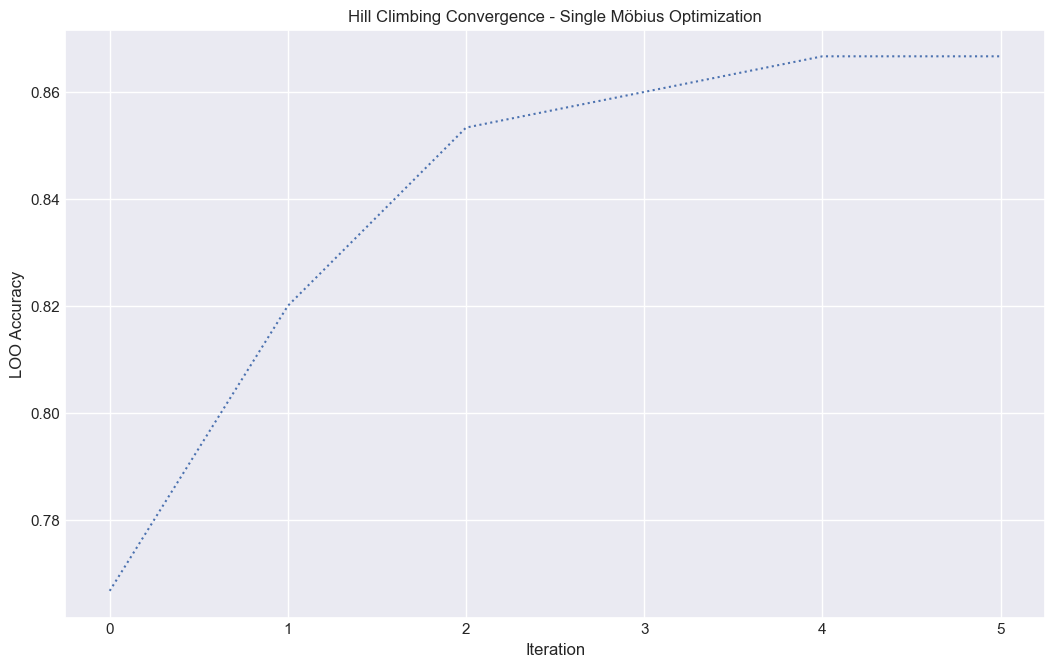

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(global_best_history, linestyle='dotted', color='b')
plt.title('Hill Climbing Convergence - Single Möbius Optimization')
plt.xlabel('Iteration')
plt.ylabel('LOO Accuracy')
plt.grid(True)
# plt.show()
# print("Convergence plot displayed")

plt.savefig(os.path.join(results_dir, timestamp, 'hill_climbing_convergence_plot_iris.png'))

In [ ]:
# Save pairs + associated mobius / capacity 
lst_X = [bst_acc[i].X for i in range(len(bst_acc))]
lst_m = [hill_climbing_best_mobius[i].X for i in range(len(hill_climbing_best_mobius))]
lst_c = [bst_acc[i].X for i in range(len(bst_acc))]

In [ ]:
m_l = []
c_l = []

In [ ]:
for i in range(len(lst_X)):
    if lst_X[i] in lst_m:
        m_l.append(locate_capacity(lst_X[i], hill_climbing_best_mobius))
    else: 
        m_l.append(0)

In [ ]:
for i in range(len(lst_X)):
    if lst_X[i] in lst_c:
        c_l.append(locate_capacity(lst_X[i], bst_acc))
    else: 
        c_l.append(0)

In [ ]:
r = []
for i in range(len(lst_X)):
    r.append({
        'index': i,
        'mobius_value': m_l[i],
        'capacity_value': c_l[i],
        'label': lst_X[i]
    })

# Save results to a txt file
results_df = pd.DataFrame(r)
results_df.to_csv(os.path.join(results_dir, timestamp, 'best_mob_cap_iris.txt'), index=False)

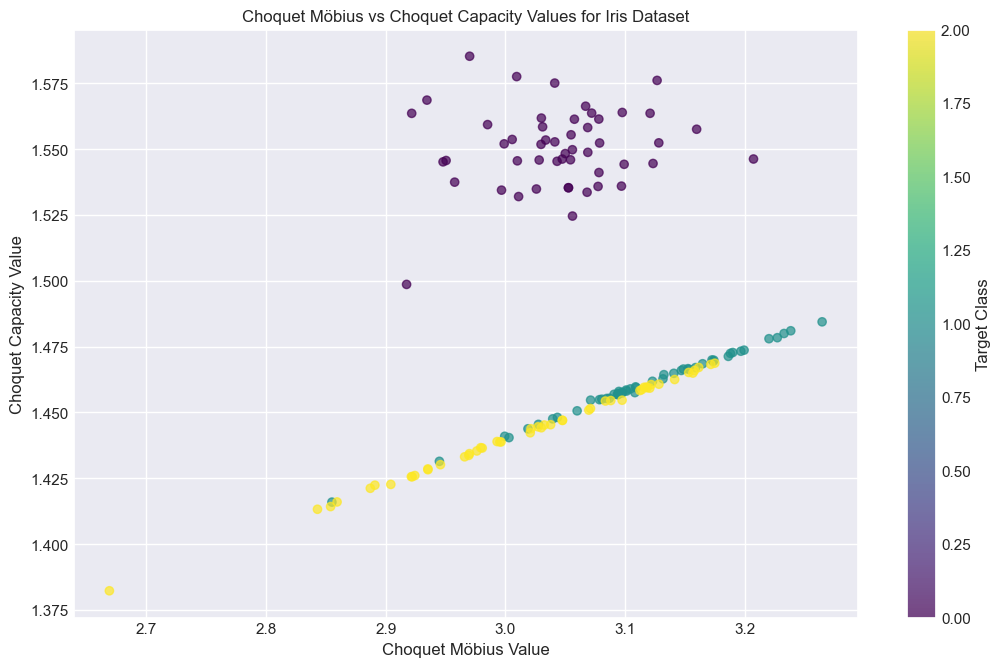

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(res_mobius, res_capacity, c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(label='Target Class')
plt.title('Choquet Möbius vs Choquet Capacity Values for Iris Dataset')
plt.xlabel('Choquet Möbius Value')
plt.ylabel('Choquet Capacity Value')
plt.grid(True)
plt.savefig(os.path.join(results_dir, timestamp, 'choquet_mobius_vs_capacity_plot_iris.png'))

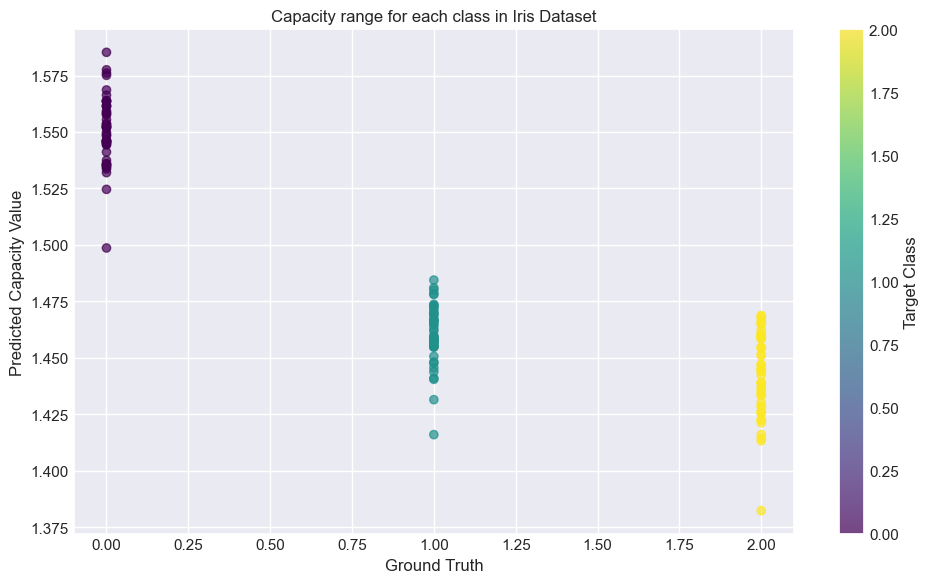

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(labels, res_capacity, c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(label='Target Class')
plt.title('Capacity range for each class in Iris Dataset')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Capacity Value')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, timestamp, 'capacity_range_plot_iris.png'))

In [ ]:
knn = KNNFuzz(input_dimension=len(data[0]),mu=bst_acc, sim=S2, p=p_val, q=q_val, k=3, choquet_version='d_choquet')
knn.train(data, labels)
predicted_labels = [
    knn.predict(data[i]) for i in range(len(data))
]

In [ ]:
from sklearn.metrics import confusion_matrix

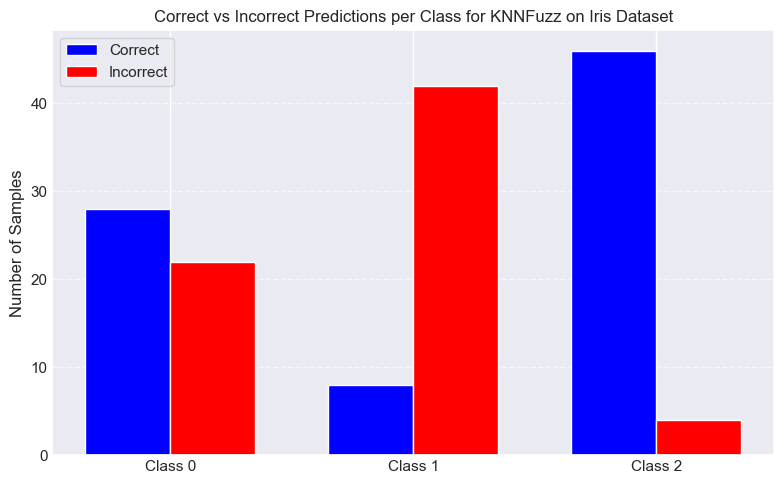

In [ ]:
# Get unique classes
classes = np.unique(labels)

# Prepare counters
correct_counts = []
incorrect_counts = []

# Loop over each class
for cls in classes:
    correct = np.sum((labels == cls) & (predicted_labels == cls))
    incorrect = np.sum((labels == cls) & (predicted_labels != cls))
    correct_counts.append(correct)
    incorrect_counts.append(incorrect)

# Plot
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, correct_counts, width, label='Correct', color='blue')
plt.bar(x + width/2, incorrect_counts, width, label='Incorrect', color='red')

plt.xticks(x, [f'Class {int(c)}' for c in classes])
plt.ylabel('Number of Samples')
plt.title('Correct vs Incorrect Predictions per Class for KNNFuzz on Iris Dataset')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(results_dir, timestamp, 'knn_fuzz_correct_vs_incorrect_iris.png'))

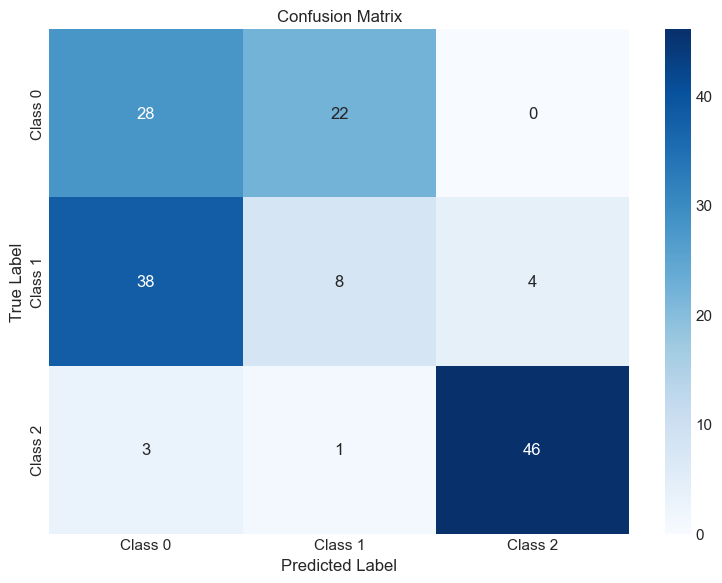

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(labels, predicted_labels)

# Get class names (optional — for better labels)
class_names = [f'Class {i}' for i in np.unique(labels)]

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(results_dir, timestamp, 'confusion_matrix_knn_fuzz_iris.png'))